> **Problem overview**

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [1]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# import skewness from scipy
from scipy.stats import skew

# import data preprocessing from sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# import model function from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import model selection from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# import model evaluation regression metrics from sklearn
from sklearn.metrics import mean_squared_error

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [3]:
# visualize head of the training data
train_df.head(n=3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
# visualize tail of the testing data
test_df.tail(n=3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [5]:
# convert training dataframe sale price to log sale price
train_df['SalePrice'] = train_df['SalePrice'].apply(lambda x: np.log1p(x))

In [6]:
# combine training and testing dataframe
train_df['DataType'], test_df['DataType'] = 'training', 'testing'
test_df.insert(test_df.shape[1] - 1, 'SalePrice', 0)
data_df = pd.concat([train_df, test_df])
data_df.head(n=3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DataType
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699,training
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016,training
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171,training


> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [7]:
# describe training and testing data
data_df.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DataType
count,2919.000000,2919.000000,2915,2433.000000,2919.000000,2919,198,2919,2919,2917,2919,2919,2919,2919,2919,2919,2919,2919.000000,2919.000000,2919.000000,2919.000000,2919,2919,2918,2918,2895,2896.000000,2919,2919,2919,2838,2837,2837,2840,2918.000000,2839,2918.000000,2918.000000,2918.000000,2919,...,2918,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2918,2919.000000,2917,2919.000000,1499,2762,2760.000000,2760,2918.000000,2918.000000,2760,2760,2919,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,10,571,105,2919.000000,2919.000000,2919.000000,2918,2919,2919.000000,2919
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN,2
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,...,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN,training
freq,NaN,NaN,2265,NaN,NaN,2907,120,1859,2622,2916,2133,2778,443,2511,2889,2425,1471,NaN,NaN,NaN,NaN,2310,2876,1025,1014,1742,NaN,1798,2538,1308,1283,2606,1904,851,NaN,2493,NaN,NaN,NaN,2874,...,2671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1492,NaN,2717,NaN,744,1723,NaN,1230,NaN,NaN,2604,2654,2641,NaN,NaN,NaN,NaN,NaN,NaN,4,329,95,NaN,NaN,NaN,2525,2402,NaN,1460
mean,1460.000000,57.137718,NaN,69.305795,10168.114080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.089072,5.564577,1971.312778,1984.264474,NaN,NaN,NaN,NaN,NaN,102.201312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,441.423235,NaN,49.582248,560.772104,1051.777587,NaN,...,NaN,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,NaN,6.451524,NaN,0.597122,NaN,NaN,1978.113406,NaN,1.766621,472.874572,NaN,NaN,NaN,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,NaN,NaN,NaN,50.825968,6.213087,2007.792737,NaN,NaN,6.014088,NaN
std,842.787043,42.517628,NaN,23.344905,7886.996359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.409947,1.113131,30.291442,20.894344,NaN,NaN,NaN,NaN,NaN,179.334253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.610826,NaN,169.205611,439.543659,440.766258,NaN,...,NaN,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,NaN,1.569379,NaN,0.646129,NaN,NaN,25.574285,NaN,0.761624,215.394815,NaN,NaN,NaN,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,NaN,NaN,NaN,567.402211,2.714762,1.314964,NaN,NaN,6.019689,NaN
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,...,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1895.0000

In [8]:
# sort training data
train_sorted_df = train_df.sort_values(by='SalePrice')

In [9]:
# box plot function 5x1 plot
def boxplot5x1(dfx, by = None, column = None):
    fig, axes = plt.subplots(figsize=(20, 3), ncols=5, nrows=1, sharey=True)
    for i, c in enumerate(by):
        sns.boxplot(ax=axes[i], data=dfx, x=c, y=column)

In [10]:
# box plot function 5x3 plot
def boxplot5x3(dfx, by = None, column = None):
    fig, axes = plt.subplots(figsize=(20, 9), ncols=5, nrows=3, sharey=True)
    axes = axes.flatten()
    for i, c in enumerate(by):
        sns.boxplot(ax=axes[i], data=dfx, x=c, y=column)

In [11]:
# box plot sorted function
def boxplotsort(dfx, by = None, column = None):
    dfy = pd.DataFrame({c: v[column] for c, v in dfx.groupby(by)})
    dfy_median = dfy.median().sort_values()
    return (dfy[dfy_median.index].boxplot(grid=False), dfy_median)

In [12]:
# feature sort coding
def featuresort(dfx, by = None, column = None):
    dfy = pd.DataFrame({c: v[column] for c, v in dfx.groupby(by)})
    dfy_median = dfy.median().sort_values()
    dfy_median = dict([[str(v), i] for i, v in enumerate(dfy_median.index)])
    data_df[by] = data_df[by].apply(lambda x: dfy_median[str(x)] if x in dfy_median.keys() else None)

In [13]:
# scatter plot function 5x1 plot
def scatterplot5x1(dfx, by = None, column = None):
    fig, axes = plt.subplots(figsize=(20, 3), ncols=5, nrows=1, sharey=True)
    for i, v in enumerate(by):
        sns.scatterplot(ax=axes[i], data=dfx, x=v, y=column)

In [14]:
# scatter plot function 5x3 plot
def scatterplot5x3(dfx, by = None, column = None):
    fig, axes = plt.subplots(figsize=(20, 9), ncols=5, nrows=3, sharey=True)
    axes = axes.flatten()
    for i, v in enumerate(by):
        sns.scatterplot(ax=axes[i], data=dfx, x=v, y=column)

In [15]:
# list all features type number
col_number = data_df.select_dtypes(include=['number']).columns.tolist()
print(col_number)
print('length %d' %len(col_number))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
length 38


In [16]:
# list all features type object
col_object = data_df.select_dtypes(include=['object']).columns.tolist()
print(col_object)
print('length %d' %len(col_object))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'DataType']
length 44


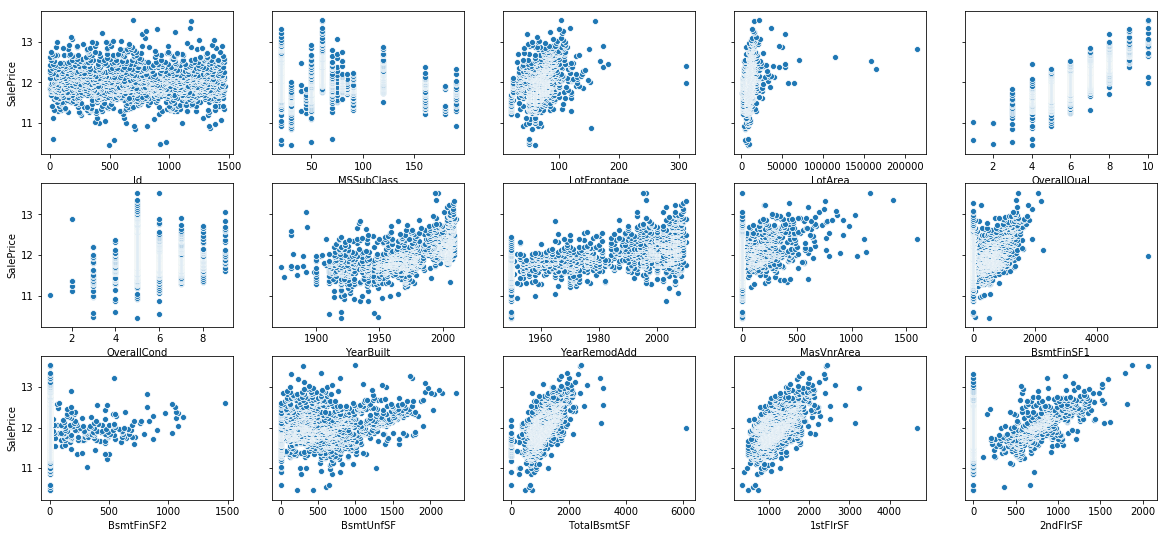

In [17]:
# scatter plot for first 15 features
scatterplot = scatterplot5x3(train_sorted_df, by=col_number[:15], column='SalePrice')

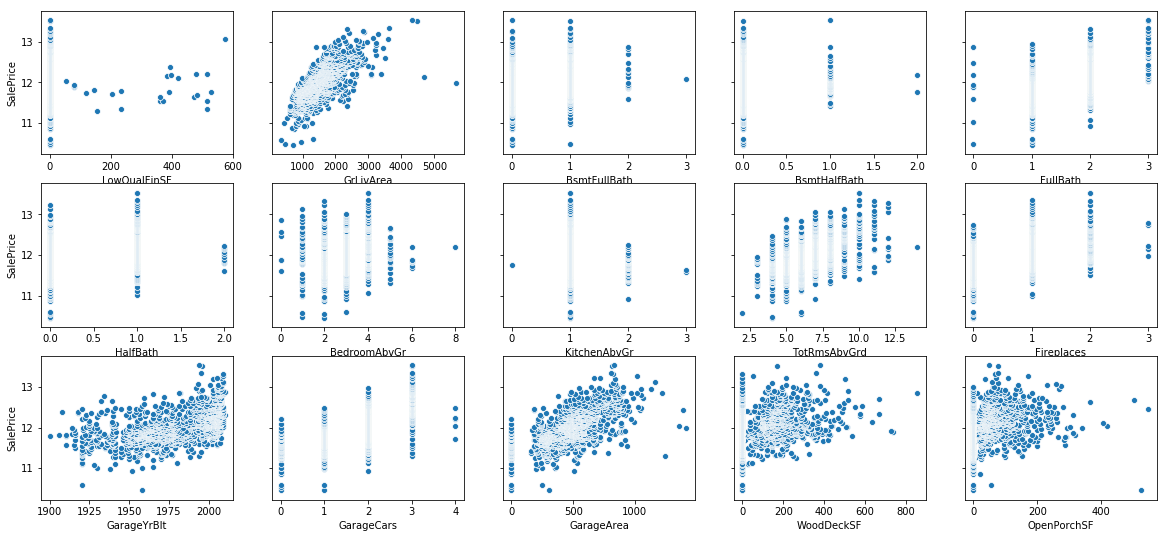

In [18]:
# scatter plot for second 15 features
scatterplot = scatterplot5x3(train_sorted_df, by=col_number[15:30], column='SalePrice')

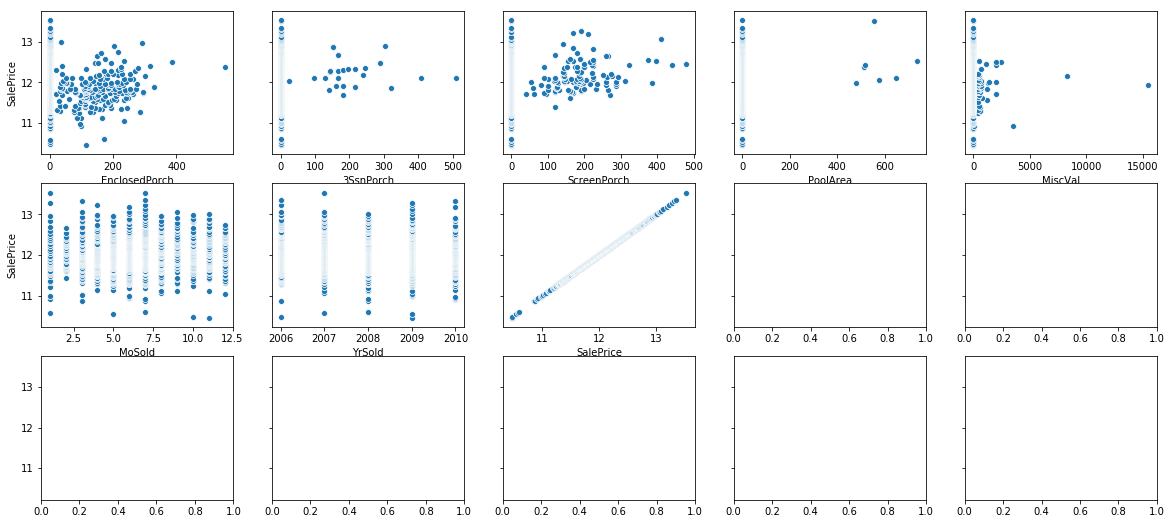

In [19]:
# scatter plot for last 15 features
scatterplot = scatterplot5x3(train_sorted_df, by=col_number[30:], column='SalePrice')

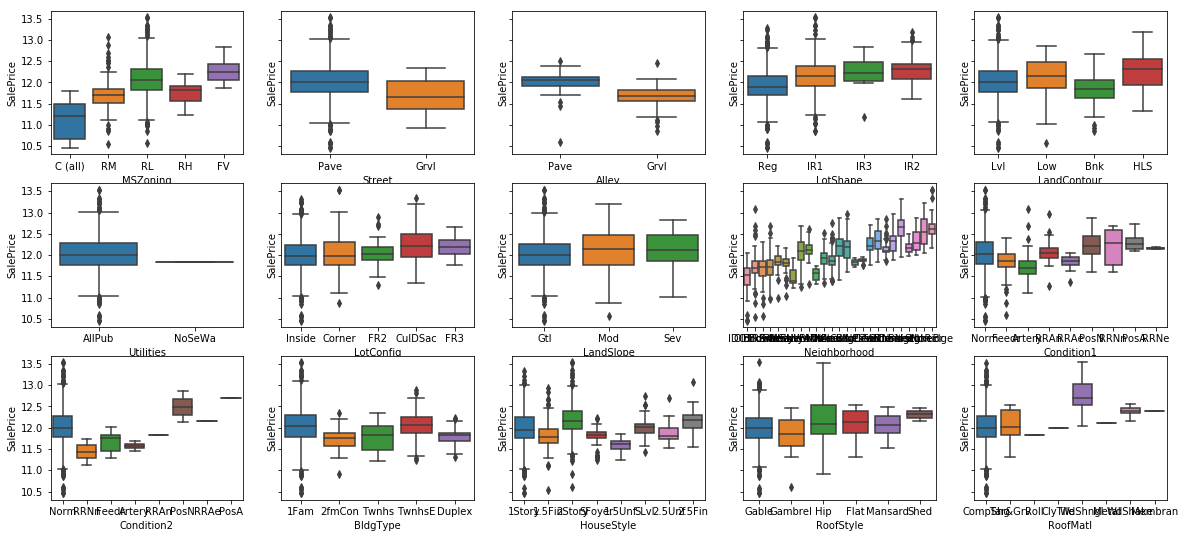

In [20]:
# box plot for first 15 features
boxplot = boxplot5x3(train_sorted_df, by=col_object[:15], column='SalePrice')

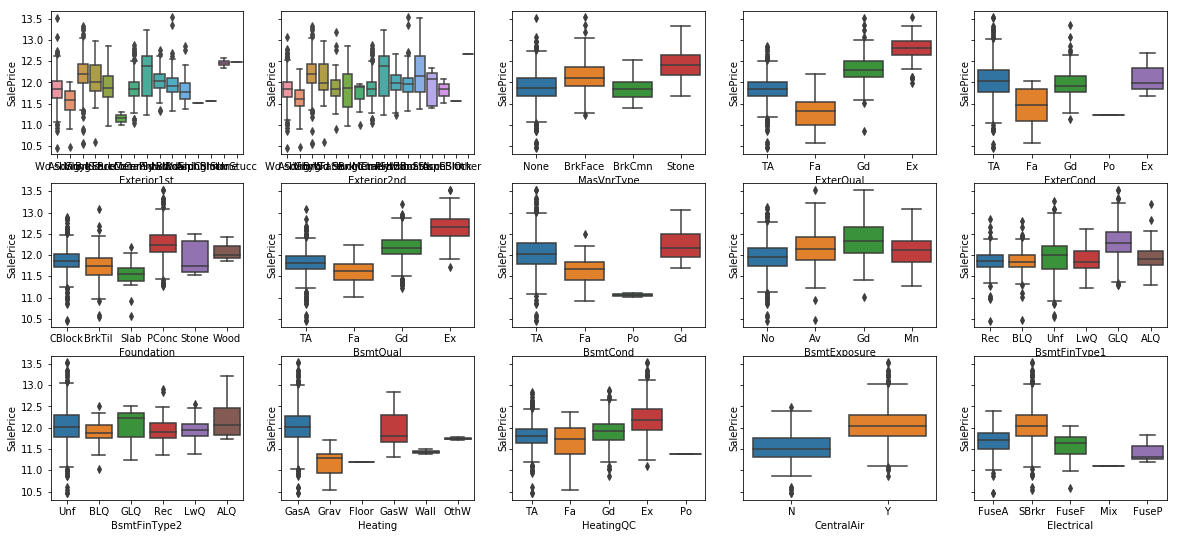

In [21]:
# box plot for second 15 features
boxplot = boxplot5x3(train_sorted_df, by=col_object[15:30], column='SalePrice')

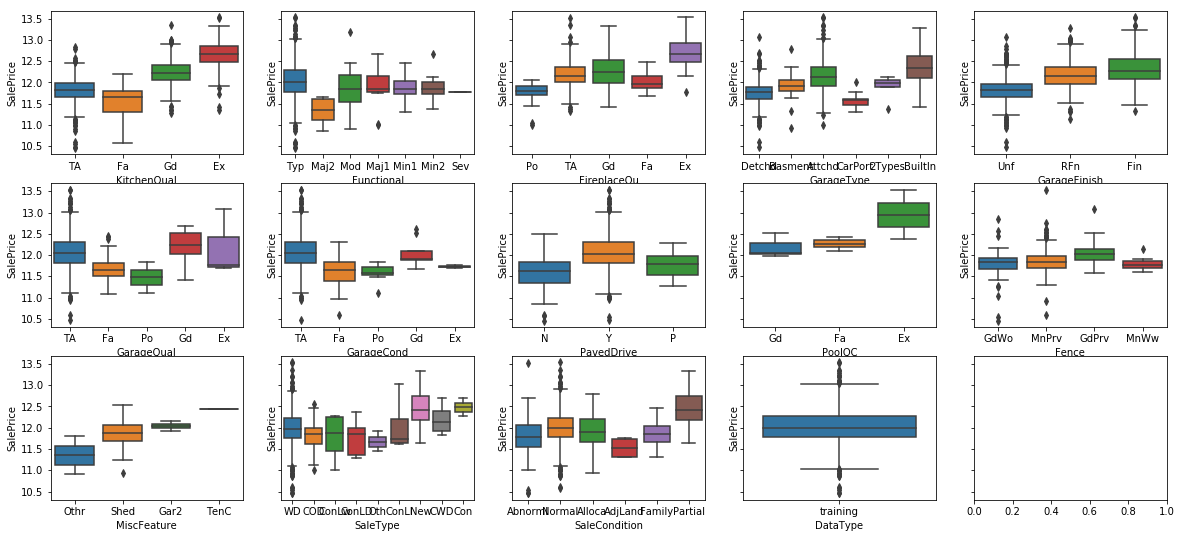

In [22]:
# box plot for last 15 features
boxplot = boxplot5x3(train_sorted_df, by=col_object[30:], column='SalePrice')

In [23]:
# feature extraction: LotFrontage
data_df.loc[(data_df['LotFrontage'] > 200) & (data_df['DataType'] == 'training'), 'DataType'] = 'excluded'

In [24]:
# feature extraction: LotArea
data_df.loc[(data_df['LotArea'] > 100000) & (data_df['DataType'] == 'training'), 'DataType'] = 'excluded'

In [25]:
# feature extraction: MasVnrArea
data_df.loc[(data_df['MasVnrArea'] > 1200) & (data_df['DataType'] == 'training'), 'DataType'] = 'excluded'

In [26]:
# feature extraction: BsmtFinSF1
data_df.loc[(data_df['BsmtFinSF1'] > 3000) & (data_df['DataType'] == 'training'), 'DataType'] = 'excluded'

In [27]:
# feature extraction: TotalBsmtSF
data_df.loc[(data_df['TotalBsmtSF'] > 4000) & (data_df['DataType'] == 'training'), 'DataType'] = 'excluded'

In [28]:
# feature extraction: 1stFlrSF
data_df.loc[(data_df['1stFlrSF'] > 4000) & (data_df['DataType'] == 'training'), 'DataType'] = 'excluded'

In [29]:
# feature extraction: GrLivArea
data_df.loc[(data_df['GrLivArea'] > 4000) & (data_df['DataType'] == 'training'), 'DataType'] = 'excluded'

In [30]:
# feature extraction: OpenPorchSF
data_df.loc[(data_df['OpenPorchSF'] > 400) & (data_df['DataType'] == 'training'), 'DataType'] = 'excluded'

In [31]:
# feature extraction: EnclosedPorch
data_df.loc[(data_df['EnclosedPorch'] > 400) & (data_df['DataType'] == 'training'), 'DataType'] = 'excluded'

In [32]:
# feature extraction: combination of keyword area
col = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
data_df[col] = data_df[col].fillna(0)
data_df['TotalSF'] = data_df['TotalBsmtSF'] + data_df['GrLivArea']
data_df['TotalPorch'] = data_df['OpenPorchSF'] + data_df['EnclosedPorch'] + data_df['3SsnPorch'] + data_df['ScreenPorch']
data_df['TotalArea'] = data_df['TotalSF'] + data_df['TotalPorch'] + data_df['GarageArea']
data_df.loc[:, col].describe(include='all')

,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,10168.114080,101.396026,441.272011,49.565262,560.579993,1051.417266,1159.581706,336.483727,4.694416,1500.759849,472.712573,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799
std,7886.996359,178.854579,455.606014,169.179104,439.590889,441.120498,392.362079,428.701456,46.396825,506.051045,215.535686,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946
min,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7478.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9453.000000,0.000000,368.000000,0.000000,467.000000,989.000000,1082.000000,0.000000,0.000000,1444.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000
75%,11570.000000,163.500000,733.000000,0.000000,805.000000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000
max,215245.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000


In [33]:
# feature extraction: combination of keyword room
col = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']
data_df[col] = data_df[col].fillna(0)
data_df['TotalBsmtBath'] = data_df['BsmtFullBath'] + data_df['BsmtHalfBath'] * 0.5
data_df['TotalAbvGrBath'] = data_df['FullBath'] + data_df['HalfBath'] * 0.5
data_df['TotalAbvGrRooms'] = data_df['TotRmsAbvGrd'] + data_df['TotalAbvGrBath']
data_df['TotalRooms'] = data_df['TotRmsAbvGrd'] + data_df['TotalBsmtBath'] + data_df['TotalAbvGrBath']
data_df.loc[:, col].describe(include='all')

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,0.429599,0.061322,1.568003,0.380267,2.860226,1.044536,6.451524
std,0.524676,0.245608,0.552969,0.502872,0.822693,0.214462,1.569379
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000
50%,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000
75%,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000
max,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000


In [34]:
# feature extraction: total area per rooms
data_df['GrLivAreaPerAbvGrRoom'] = data_df['GrLivArea'] / data_df['TotalAbvGrRooms']
data_df['TotalAreaPerAbvGrRoom'] = data_df['TotalArea'] / data_df['TotalAbvGrRooms']
data_df['GrLivAreaPerRoom'] = data_df['GrLivArea'] / data_df['TotalRooms']
data_df['TotalAreaPerRoom'] = data_df['TotalArea'] / data_df['TotalRooms']

In [35]:
# feature extraction: overall quality and condition
data_df['OverallQualCond'] = data_df['OverallQual'] + data_df['OverallCond']

In [36]:
# feature extraction: combination of keyword year
data_df['GarageYrBlt'] = data_df['GarageYrBlt'].fillna(data_df['YearBuilt'])
data_df['YearBuiltSold'] = data_df['YrSold'] - data_df['YearBuilt']
data_df['YearRemodSold'] = data_df['YrSold'] - data_df['YearRemodAdd']
data_df['YearGarageSold'] = data_df['YrSold'] - data_df['GarageYrBlt']

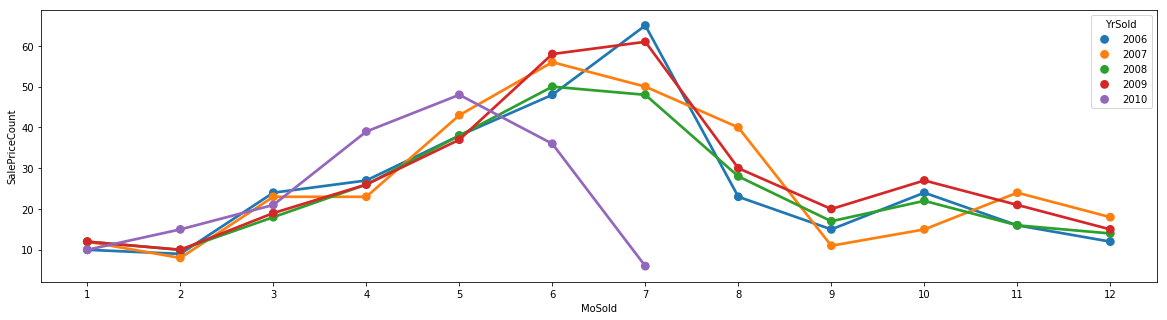

In [37]:
# feature extraction: season
groupby = data_df[data_df['DataType'] == 'training'].groupby(['YrSold', 'MoSold'])
groupby = groupby.count()['SalePrice'].reset_index()
groupby.columns = ['YrSold', 'MoSold', 'SalePriceCount']

fig, ax = plt.subplots(figsize=(20, 5))
pointplot = sns.pointplot(data=groupby, join=True, hue='YrSold', x='MoSold', y='SalePriceCount')
data_df['Season'] = data_df['MoSold'].map({1: 0, 2: 0, 3: 0, 4: 1, 5: 2, 6: 3, 7: 3, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0})

In [38]:
# feature extraction: MSSubClass
data_df['MSSubClass'] = data_df['MSSubClass'].astype(str)
featuresort(train_df, 'MSSubClass', 'SalePrice')

In [39]:
# feature extraction: change all category features to median sorting
for col in col_object[:-1]:
    featuresort(train_df, col, 'SalePrice')

In [40]:
# feature extraction: simple fillna for all columns
for col in data_df.select_dtypes(include=['number']).columns.tolist():
    skewness = skew(data_df[col].dropna())
    if skewness > 0.75: data_df[col] = np.log1p(data_df[col])
    data_df[col] = data_df[col].fillna(0)
for col in data_df.select_dtypes(include=['object']).columns.tolist():
    data_df[col] = data_df[col].fillna('None')

In [41]:
# feature extraction: DataType
data_df['DataType'] = data_df['DataType'].map({'testing': 0, 'training': 1, 'excluded': '2'})

In [42]:
data_df.head(n=3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DataType,TotalSF,TotalPorch,TotalArea,TotalBsmtBath,TotalAbvGrBath,TotalAbvGrRooms,TotalRooms,GrLivAreaPerAbvGrRoom,TotalAreaPerAbvGrRoom,GrLivAreaPerRoom,TotalAreaPerRoom,OverallQualCond,YearBuiltSold,YearRemodSold,YearGarageSold,Season
0,1,14.0,3.0,4.189655,9.042040,1,0.0,0.000000,0.693147,1.0,0.000000,0.0,16,3,4,3,6,7,5,2003,2003,0.693147,1.098612,11.0,13.0,1.098612,5.283204,1.098612,4,5,2.0,2.0,0.000000,5.0,6.561031,3.0,0.0,5.017280,6.753438,5,...,4.0,2003.0,1.0,2.0,548.0,3.0,4.0,2,0.000000,4.127134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2008,5.0,4,12.247699,1,7.850493,4.127134,8.063378,1.0,2.5,10.5,11.5,5.098995,302.380952,5.008604,276.086957,12,5,5,5.0,0
1,2,10.0,3.0,4.394449,9.169623,1,0.0,0.000000,0.693147,1.0,1.098612,0.0,19,1,4,3,4,6,8,1976,1976,0.693147,1.098612,6.0,4.0,0.693147,0.000000,0.693147,4,3,2.0,2.0,1.386294,3.0,6.886532,3.0,0.0,5.652489,7.141245,5,...,4.0,1976.0,1.0,2.0,460.0,3.0,4.0,2,5.700444,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2007,5.0,4,12.109016,1,7.833996,0.000000,8.001355,0.5,2.0,8.0,8.5,5.067331,373.000000,5.007100,351.058824,14,31,31,31.0,2
2,3,14.0,3.0,4.234107,9.328212,1,0.0,0.693147,0.693147,1.0,0.000000,0.0,16,3,4,3,6,7,5,2001,2002,0.693147,1.098612,11.0,13.0,1.098612,5.093750,1.098612,4,5,2.0,2.0,0.693147,5.0,6.188264,3.0,0.0,6.075346,6.825460,5,...,4.0,2001.0,1.0,2.0,608.0,3.0,4.0,2,0.000000,3.761200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2008,5.0,4,12.317171,1,7.903596,3.761200,8.118803,1.0,2.5,8.5,9.5,5.352416,394.823529,5.241747,353.263158,12,7,6,7.0,0


After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [43]:
# verify dtypes object
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 98 columns):
Id                       2919 non-null int64
MSSubClass               2919 non-null float64
MSZoning                 2919 non-null float64
LotFrontage              2919 non-null float64
LotArea                  2919 non-null float64
Street                   2919 non-null int64
Alley                    2919 non-null float64
LotShape                 2919 non-null float64
LandContour              2919 non-null float64
Utilities                2919 non-null float64
LotConfig                2919 non-null float64
LandSlope                2919 non-null float64
Neighborhood             2919 non-null int64
Condition1               2919 non-null int64
Condition2               2919 non-null int64
BldgType                 2919 non-null int64
HouseStyle               2919 non-null int64
OverallQual              2919 non-null int64
OverallCond              2919 non-null int64
YearBuilt         

In [44]:
# convert dtypes object to category
col_obj = data_df.select_dtypes(['object']).columns
data_df[col_obj] = data_df[col_obj].astype('category')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 98 columns):
Id                       2919 non-null int64
MSSubClass               2919 non-null float64
MSZoning                 2919 non-null float64
LotFrontage              2919 non-null float64
LotArea                  2919 non-null float64
Street                   2919 non-null int64
Alley                    2919 non-null float64
LotShape                 2919 non-null float64
LandContour              2919 non-null float64
Utilities                2919 non-null float64
LotConfig                2919 non-null float64
LandSlope                2919 non-null float64
Neighborhood             2919 non-null int64
Condition1               2919 non-null int64
Condition2               2919 non-null int64
BldgType                 2919 non-null int64
HouseStyle               2919 non-null int64
OverallQual              2919 non-null int64
OverallCond              2919 non-null int64
YearBuilt         

In [45]:
# convert dtypes category to category codes
col_cat = data_df.select_dtypes(['category']).columns
data_df[col_cat] = data_df[col_cat].apply(lambda x: x.cat.codes)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 98 columns):
Id                       2919 non-null int64
MSSubClass               2919 non-null float64
MSZoning                 2919 non-null float64
LotFrontage              2919 non-null float64
LotArea                  2919 non-null float64
Street                   2919 non-null int64
Alley                    2919 non-null float64
LotShape                 2919 non-null float64
LandContour              2919 non-null float64
Utilities                2919 non-null float64
LotConfig                2919 non-null float64
LandSlope                2919 non-null float64
Neighborhood             2919 non-null int64
Condition1               2919 non-null int64
Condition2               2919 non-null int64
BldgType                 2919 non-null int64
HouseStyle               2919 non-null int64
OverallQual              2919 non-null int64
OverallCond              2919 non-null int64
YearBuilt         

In [46]:
data_df.head(n=3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DataType,TotalSF,TotalPorch,TotalArea,TotalBsmtBath,TotalAbvGrBath,TotalAbvGrRooms,TotalRooms,GrLivAreaPerAbvGrRoom,TotalAreaPerAbvGrRoom,GrLivAreaPerRoom,TotalAreaPerRoom,OverallQualCond,YearBuiltSold,YearRemodSold,YearGarageSold,Season
0,1,14.0,3.0,4.189655,9.042040,1,0.0,0.000000,0.693147,1.0,0.000000,0.0,16,3,4,3,6,7,5,2003,2003,0.693147,1.098612,11.0,13.0,1.098612,5.283204,1.098612,4,5,2.0,2.0,0.000000,5.0,6.561031,3.0,0.0,5.017280,6.753438,5,...,4.0,2003.0,1.0,2.0,548.0,3.0,4.0,2,0.000000,4.127134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2008,5.0,4,12.247699,1,7.850493,4.127134,8.063378,1.0,2.5,10.5,11.5,5.098995,302.380952,5.008604,276.086957,12,5,5,5.0,0
1,2,10.0,3.0,4.394449,9.169623,1,0.0,0.000000,0.693147,1.0,1.098612,0.0,19,1,4,3,4,6,8,1976,1976,0.693147,1.098612,6.0,4.0,0.693147,0.000000,0.693147,4,3,2.0,2.0,1.386294,3.0,6.886532,3.0,0.0,5.652489,7.141245,5,...,4.0,1976.0,1.0,2.0,460.0,3.0,4.0,2,5.700444,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2007,5.0,4,12.109016,1,7.833996,0.000000,8.001355,0.5,2.0,8.0,8.5,5.067331,373.000000,5.007100,351.058824,14,31,31,31.0,2
2,3,14.0,3.0,4.234107,9.328212,1,0.0,0.693147,0.693147,1.0,0.000000,0.0,16,3,4,3,6,7,5,2001,2002,0.693147,1.098612,11.0,13.0,1.098612,5.093750,1.098612,4,5,2.0,2.0,0.693147,5.0,6.188264,3.0,0.0,6.075346,6.825460,5,...,4.0,2001.0,1.0,2.0,608.0,3.0,4.0,2,0.000000,3.761200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2008,5.0,4,12.317171,1,7.903596,3.761200,8.118803,1.0,2.5,8.5,9.5,5.352416,394.823529,5.241747,353.263158,12,7,6,7.0,0


> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

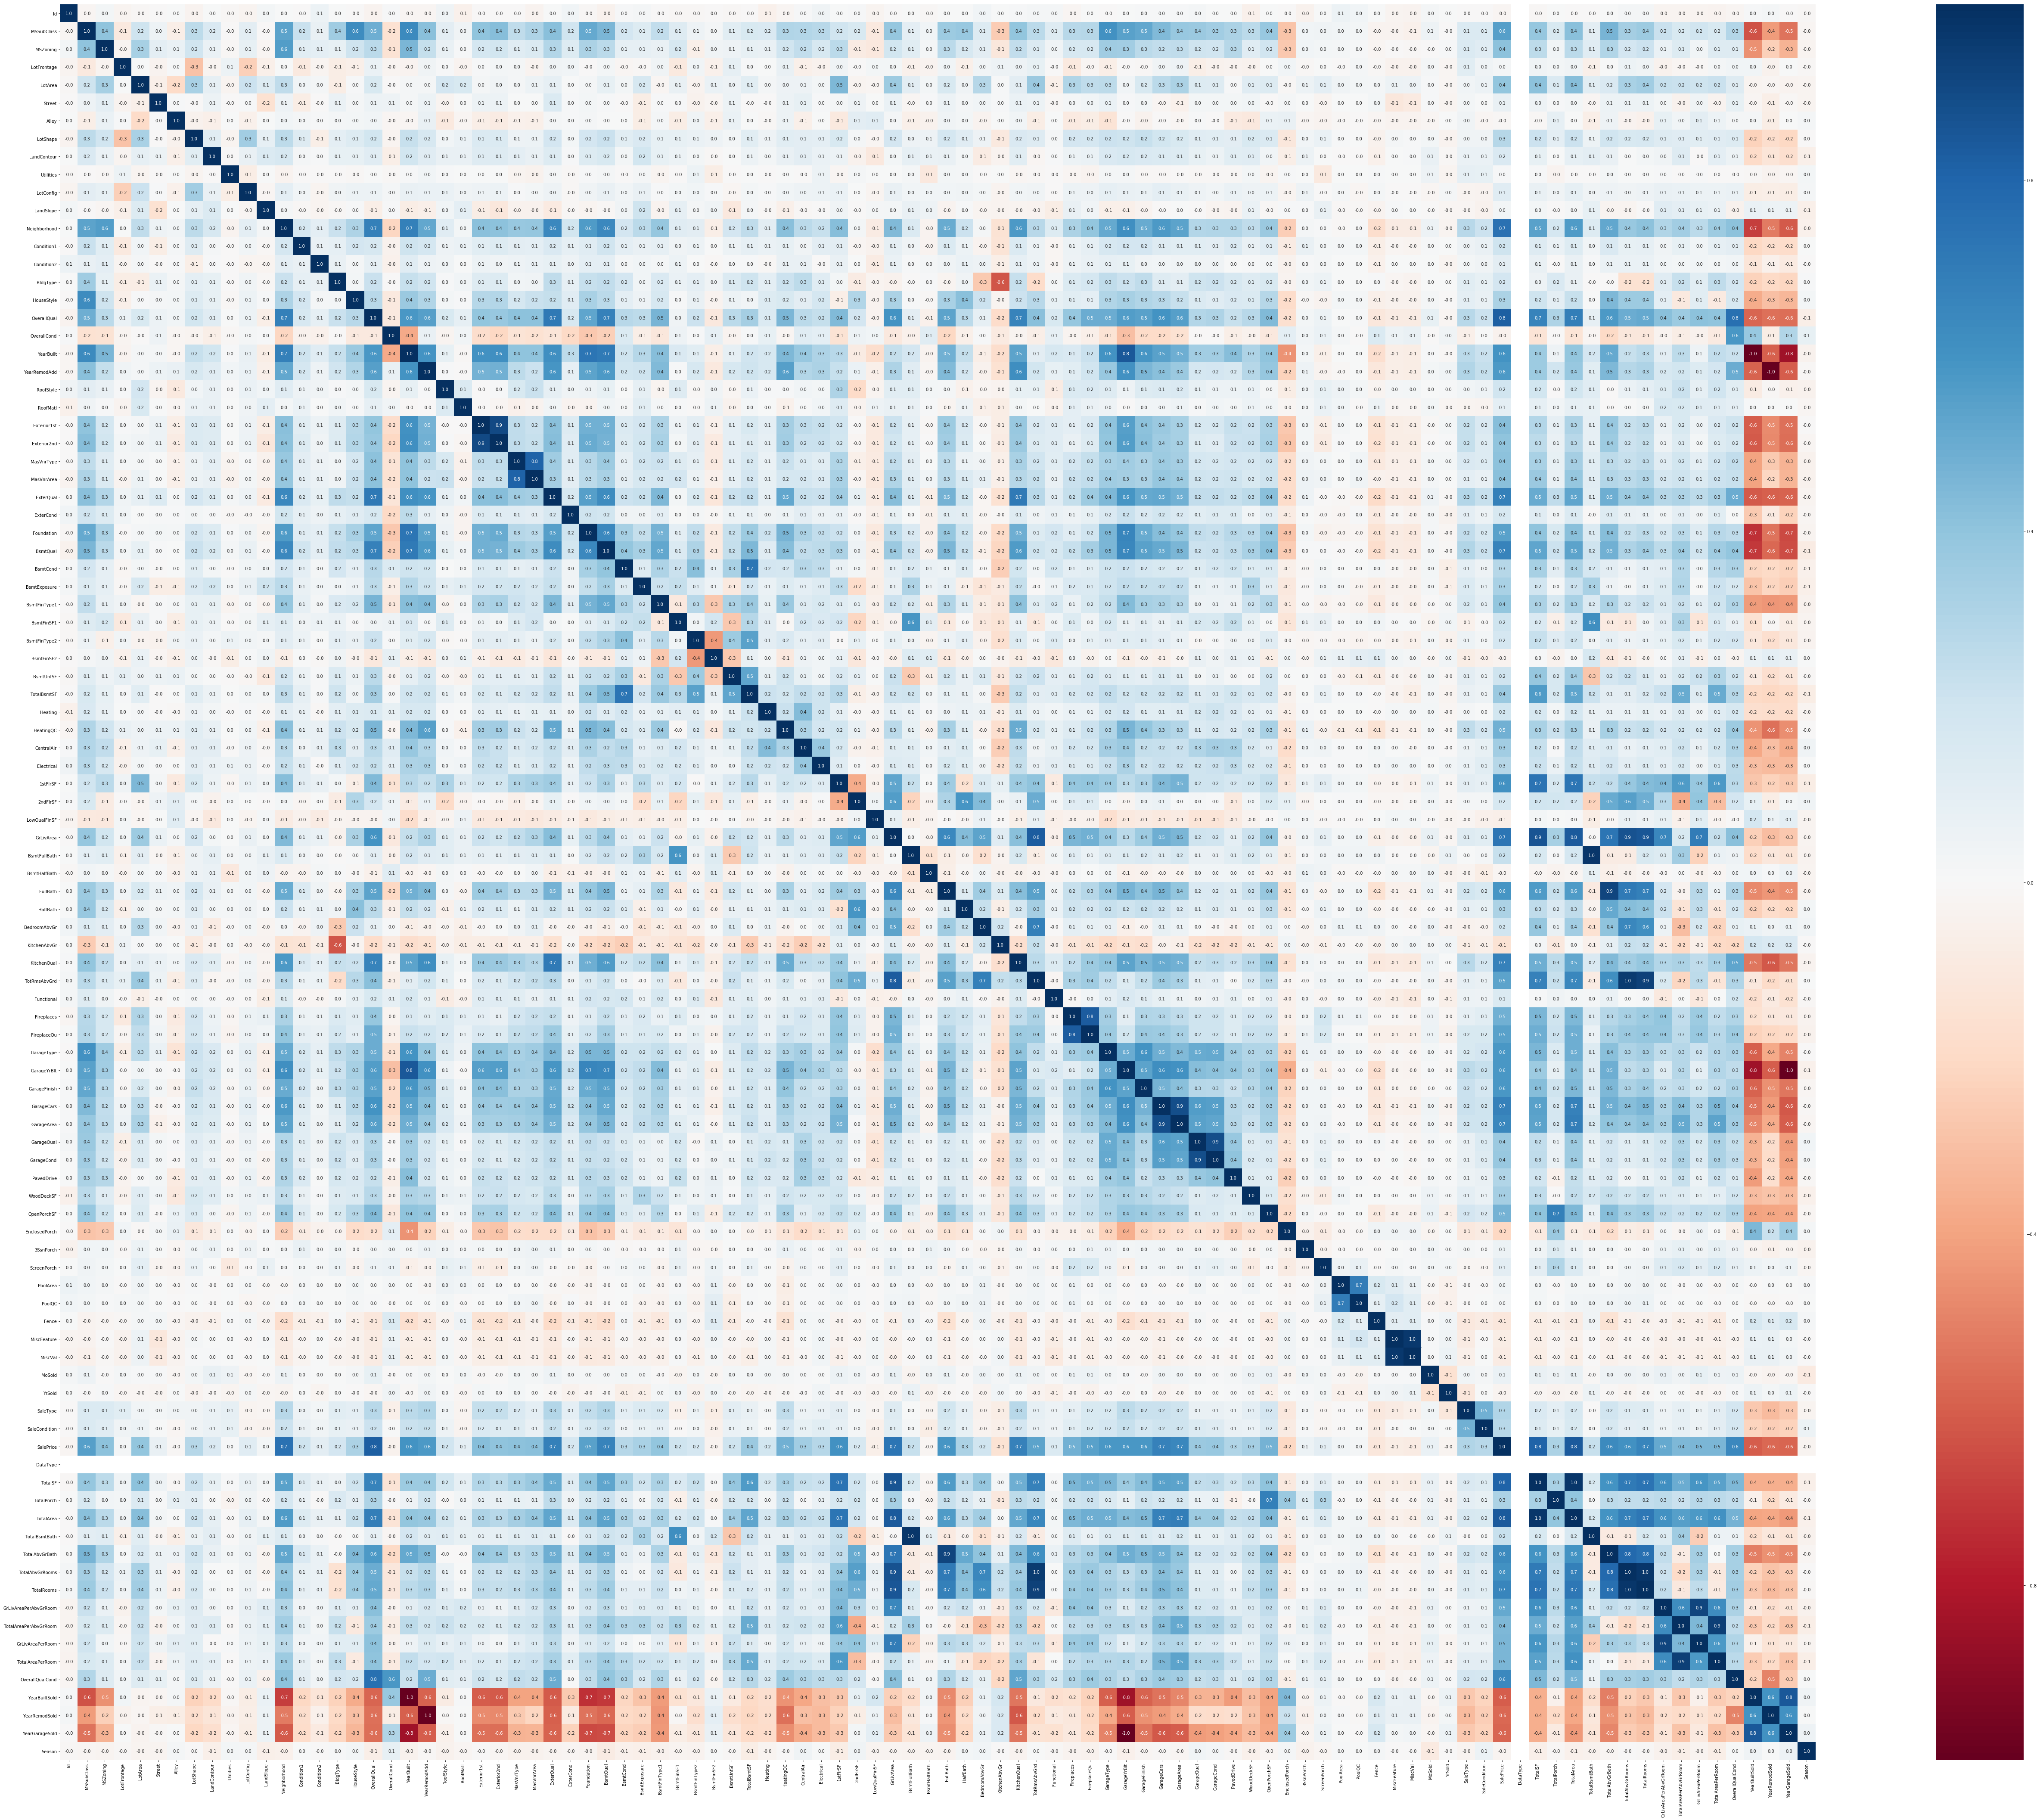

In [47]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = data_df[data_df['DataType'] == 1].corr()
fig, ax = plt.subplots(figsize=(100, 75))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True);

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

In [48]:
# plot pairwise relationships in a dataset
#pairplot = sns.pairplot(data_df[data_df['DataType'] == 1], diag_kind='kde', diag_kws=dict(shade=True), hue='SalePrice')

The pivot table and other visulized plots are also another useful methods to observe the impact between features.

In [49]:
# pivot table
pivottable = pd.pivot_table(data_df[data_df['DataType'] == 1], aggfunc=np.mean,
                            columns=['SaleType'], index=['YearBuilt'], values='SalePrice')
pivottable.style.background_gradient(cmap='Blues')

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


SaleType,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
YearBuilt,,,,,,,,,
1872,nan,nan,nan,nan,nan,11.7118,nan,nan,nan
1875,nan,nan,nan,nan,nan,11.4511,nan,nan,nan
1880,nan,nan,nan,nan,nan,12.122,nan,nan,nan
1882,nan,nan,nan,nan,nan,12.0317,nan,nan,nan
1885,nan,nan,nan,nan,nan,11.6144,nan,nan,nan
1890,nan,nan,nan,nan,nan,11.8575,nan,nan,nan
1892,nan,nan,nan,nan,nan,12.3282,nan,nan,nan
1898,nan,nan,nan,nan,nan,11.5712,nan,nan,nan
1900,nan,nan,nan,11.9829,nan,11.5623,nan,nan,nan


> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [50]:
# select all features to evaluate the feature importances
x = data_df[data_df['DataType'] == 1].drop(['Id', 'SalePrice'], axis=1)
y = data_df[data_df['DataType'] == 1]['SalePrice']

In [51]:
x.head(n=3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,DataType,TotalSF,TotalPorch,TotalArea,TotalBsmtBath,TotalAbvGrBath,TotalAbvGrRooms,TotalRooms,GrLivAreaPerAbvGrRoom,TotalAreaPerAbvGrRoom,GrLivAreaPerRoom,TotalAreaPerRoom,OverallQualCond,YearBuiltSold,YearRemodSold,YearGarageSold,Season
0,14.0,3.0,4.189655,9.042040,1,0.0,0.000000,0.693147,1.0,0.000000,0.0,16,3,4,3,6,7,5,2003,2003,0.693147,1.098612,11.0,13.0,1.098612,5.283204,1.098612,4,5,2.0,2.0,0.000000,5.0,6.561031,3.0,0.0,5.017280,6.753438,5,4,...,0.0,4.0,2003.0,1.0,2.0,548.0,3.0,4.0,2,0.000000,4.127134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2008,5.0,4,1,7.850493,4.127134,8.063378,1.0,2.5,10.5,11.5,5.098995,302.380952,5.008604,276.086957,12,5,5,5.0,0
1,10.0,3.0,4.394449,9.169623,1,0.0,0.000000,0.693147,1.0,1.098612,0.0,19,1,4,3,4,6,8,1976,1976,0.693147,1.098612,6.0,4.0,0.693147,0.000000,0.693147,4,3,2.0,2.0,1.386294,3.0,6.886532,3.0,0.0,5.652489,7.141245,5,4,...,2.0,4.0,1976.0,1.0,2.0,460.0,3.0,4.0,2,5.700444,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2007,5.0,4,1,7.833996,0.000000,8.001355,0.5,2.0,8.0,8.5,5.067331,373.000000,5.007100,351.058824,14,31,31,31.0,2
2,14.0,3.0,4.234107,9.328212,1,0.0,0.693147,0.693147,1.0,0.000000,0.0,16,3,4,3,6,7,5,2001,2002,0.693147,1.098612,11.0,13.0,1.098612,5.093750,1.098612,4,5,2.0,2.0,0.693147,5.0,6.188264,3.0,0.0,6.075346,6.825460,5,4,...,2.0,4.0,2001.0,1.0,2.0,608.0,3.0,4.0,2,0.000000,3.761200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2008,5.0,4,1,7.903596,3.761200,8.118803,1.0,2.5,8.5,9.5,5.352416,394.823529,5.241747,353.263158,12,7,6,7.0,0


In [52]:
# set up random forest regressor to find the feature importances
forestreg = RandomForestRegressor(max_depth=99, n_estimators=2000, random_state=0).fit(x, y)
feat = pd.DataFrame(data=forestreg.feature_importances_, index=x.columns, columns=['FeatureImportances']).sort_values(['FeatureImportances'], ascending=False)

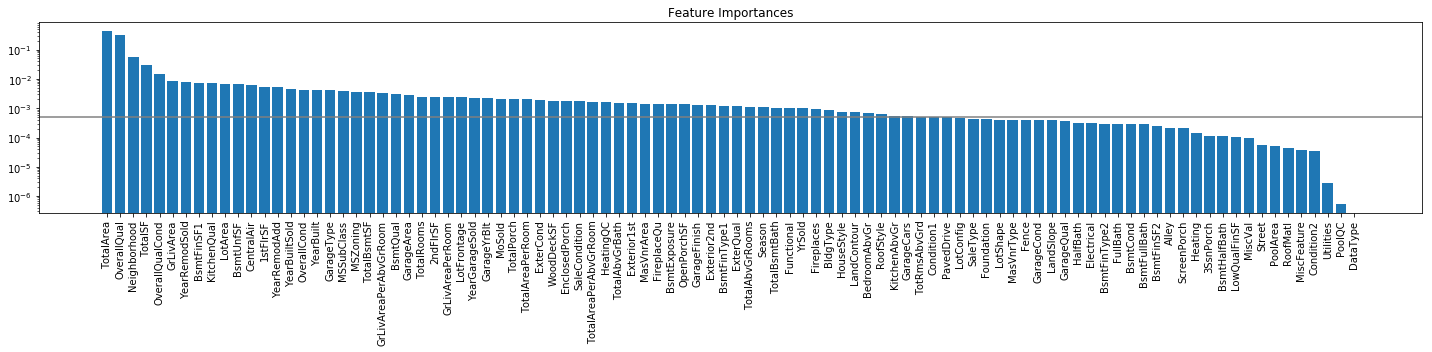

In [53]:
# plot the feature importances
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Feature Importances')
plt.bar(feat.index, feat['FeatureImportances'])
plt.axhline(0.0005, color="grey")
ax.set_xticklabels(feat.index, rotation='vertical')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [54]:
# list all features
data_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [55]:
# list feature importances
feat[feat['FeatureImportances'] > 0.0005].index

Index(['TotalArea', 'OverallQual', 'Neighborhood', 'TotalSF',
       'OverallQualCond', 'GrLivArea', 'YearRemodSold', 'BsmtFinSF1',
       'KitchenQual', 'LotArea', 'BsmtUnfSF', 'CentralAir', '1stFlrSF',
       'YearRemodAdd', 'YearBuiltSold', 'OverallCond', 'YearBuilt',
       'GarageType', 'MSSubClass', 'MSZoning', 'TotalBsmtSF',
       'GrLivAreaPerAbvGrRoom', 'BsmtQual', 'GarageArea', 'TotalRooms',
       '2ndFlrSF', 'GrLivAreaPerRoom', 'LotFrontage', 'YearGarageSold',
       'GarageYrBlt', 'MoSold', 'TotalPorch', 'TotalAreaPerRoom', 'ExterCond',
       'WoodDeckSF', 'EnclosedPorch', 'SaleCondition', 'TotalAreaPerAbvGrRoom',
       'HeatingQC', 'TotalAbvGrBath', 'Exterior1st', 'MasVnrArea',
       'FireplaceQu', 'BsmtExposure', 'OpenPorchSF', 'GarageFinish',
       'Exterior2nd', 'BsmtFinType1', 'ExterQual', 'TotalAbvGrRooms', 'Season',
       'TotalBsmtBath', 'Functional', 'YrSold', 'Fireplaces', 'BldgType',
       'HouseStyle', 'LandContour', 'BedroomAbvGr', 'RoofStyle',
       '

In [56]:
# select the important features
x = data_df[data_df['DataType'] == 1][feat[feat['FeatureImportances'] > 0.0005].index]
y = data_df[data_df['DataType'] == 1]['SalePrice']

In [57]:
x.head(n=3)

,TotalArea,OverallQual,Neighborhood,TotalSF,OverallQualCond,GrLivArea,YearRemodSold,BsmtFinSF1,KitchenQual,LotArea,BsmtUnfSF,CentralAir,1stFlrSF,YearRemodAdd,YearBuiltSold,OverallCond,YearBuilt,GarageType,MSSubClass,MSZoning,TotalBsmtSF,GrLivAreaPerAbvGrRoom,BsmtQual,GarageArea,TotalRooms,2ndFlrSF,GrLivAreaPerRoom,LotFrontage,YearGarageSold,GarageYrBlt,MoSold,TotalPorch,TotalAreaPerRoom,ExterCond,WoodDeckSF,EnclosedPorch,SaleCondition,TotalAreaPerAbvGrRoom,HeatingQC,TotalAbvGrBath,Exterior1st,MasVnrArea,FireplaceQu,BsmtExposure,OpenPorchSF,GarageFinish,Exterior2nd,BsmtFinType1,ExterQual,TotalAbvGrRooms,Season,TotalBsmtBath,Functional,YrSold,Fireplaces,BldgType,HouseStyle,LandContour,BedroomAbvGr,RoofStyle,KitchenAbvGr,GarageCars,TotRmsAbvGrd,Condition1
0,8.063378,7,16,7.850493,12,7.444833,5,6.561031,2.0,9.042040,5.017280,1,6.753438,2003,5,5,2003,4.0,14.0,3.0,6.753438,5.098995,2.0,548.0,11.5,6.751101,5.008604,4.189655,5.0,2003.0,2,4.127134,276.086957,4,0.000000,0.0,4,302.380952,4,2.5,11.0,5.283204,0.0,0.000000,4.127134,1.0,13.0,5.0,1.098612,10.5,0,1.0,6.0,2008,0,3,6,0.693147,3,0.693147,0.693147,2.0,2.197225,3
1,8.001355,6,19,7.833996,14,7.141245,31,6.886532,1.0,9.169623,5.652489,1,7.141245,1976,31,8,1976,4.0,10.0,3.0,7.141245,5.067331,2.0,460.0,8.5,0.000000,5.007100,4.394449,31.0,1976.0,5,0.000000,351.058824,4,5.700444,0.0,4,373.000000,4,2.0,6.0,0.000000,2.0,1.386294,0.000000,1.0,4.0,3.0,0.693147,8.0,2,0.5,6.0,2007,1,3,4,0.693147,3,0.693147,0.693147,2.0,1.945910,1
2,8.118803,7,16,7.903596,12,7.488294,6,6.188264,2.0,9.328212,6.075346,1,6.825460,2002,7,5,2001,4.0,14.0,3.0,6.825460,5.352416,2.0,608.0,9.5,6.765039,5.241747,4.234107,7.0,2001.0,9,3.761200,353.263158,4,0.000000,0.0,4,394.823529,4,2.5,11.0,5.093750,2.0,0.693147,3.761200,1.0,13.0,5.0,1.098612,8.5,0,1.0,6.0,2008,1,3,6,0.693147,3,0.693147,0.693147,2.0,1.945910,3


In [58]:
# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

In [59]:
# create pca to decorrelate the features
pca = PCA(n_components=50)
x = pca.fit_transform(x)

In [60]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=0, test_size=0.25)

In [61]:
# model prediction
linreg = LinearRegression().fit(x_train, y_train)
linreg_ypredict = linreg.predict(x_validate)
linreg_mse = mean_squared_error(y_validate, linreg_ypredict) ** 0.5
linreg_cvscores = np.sqrt(np.abs(cross_val_score(linreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('linear regression\n  mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(linreg_mse, linreg_cvscores.mean(), 2 * linreg_cvscores.std()))

lassoreg = Lasso(alpha=0.001).fit(x_train, y_train)
lassoreg_ypredict = lassoreg.predict(x_validate)
lassoreg_mse = mean_squared_error(y_validate, lassoreg_ypredict) ** 0.5
lassoreg_cvscores = np.sqrt(np.abs(cross_val_score(lassoreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('lasso regression\n  mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(lassoreg_mse, lassoreg_cvscores.mean(), 2 * lassoreg_cvscores.std()))

ridgereg = Ridge(alpha=10).fit(x_train, y_train)
ridgereg_ypredict = ridgereg.predict(x_validate)
ridgereg_mse = mean_squared_error(y_validate, ridgereg_ypredict) ** 0.5
ridgereg_cvscores = np.sqrt(np.abs(cross_val_score(ridgereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('ridge regression\n  mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(ridgereg_mse, ridgereg_cvscores.mean(), 2 * ridgereg_cvscores.std()))

kernelridgereg = KernelRidge(alpha=10, coef0=10, degree=1, kernel='polynomial').fit(x_train, y_train)
kernelridgereg_ypredict = kernelridgereg.predict(x_validate)
kernelridgereg_mse = mean_squared_error(y_validate, kernelridgereg_ypredict) ** 0.5
kernelridgereg_cvscores = np.sqrt(np.abs(cross_val_score(kernelridgereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('kernel ridge regression\n  mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(kernelridgereg_mse, kernelridgereg_cvscores.mean(), 2 * kernelridgereg_cvscores.std()))

treereg = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, splitter='best').fit(x_train, y_train)
treereg_ypredict = treereg.predict(x_validate)
treereg_mse = mean_squared_error(y_validate, treereg_ypredict) ** 0.5
treereg_cvscores = np.sqrt(np.abs(cross_val_score(treereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('decision tree regression\n  mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(treereg_mse, treereg_cvscores.mean(), 2 * treereg_cvscores.std()))

forestreg = RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=250, random_state=0).fit(x_train, y_train)
forestreg_ypredict = forestreg.predict(x_validate)
forestreg_mse = mean_squared_error(y_validate, forestreg_ypredict) ** 0.5
forestreg_cvscores = np.sqrt(np.abs(cross_val_score(forestreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('random forest regression\n  mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(forestreg_mse, forestreg_cvscores.mean(), 2 * forestreg_cvscores.std()))

linear regression
  mean squared error: 0.1214, cross validation score: 0.1137 (+/- 0.0102)
lasso regression
  mean squared error: 0.1206, cross validation score: 0.1134 (+/- 0.0108)
ridge regression
  mean squared error: 0.1210, cross validation score: 0.1134 (+/- 0.0104)
kernel ridge regression
  mean squared error: 0.1224, cross validation score: 0.1190 (+/- 0.0122)
decision tree regression
  mean squared error: 0.1662, cross validation score: 0.1715 (+/- 0.0060)
random forest regression
  mean squared error: 0.1429, cross validation score: 0.1361 (+/- 0.0111)


> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [62]:
# model selection
model = ridgereg

# prepare testing data and compute the observed value
x_test = data_df[data_df['DataType'] == 0][feat[feat['FeatureImportances'] > 0.0005].index]
x_test = scaler.transform(x_test)
x_test = pca.transform(x_test)
y_test = pd.DataFrame(np.expm1(model.predict(x_test)), columns=['SalePrice'])

In [63]:
# summit the results
out = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': y_test['SalePrice']})
out.to_csv('submission.csv', index=False)